In [1]:
# import the necessary packages
from IPython.display import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import load_model

#this two lines must be included to enable parallel computation
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# load the trained model from disk
print("[INFO] loading privacy model...")
privacy_model = load_model('privacy.model')
print("[INFO] loading VGG16 model...")
object_model = VGG16()
print("[INFO] loading Places365 model...")
places_model = load_model('places_model.h5')

Using TensorFlow backend.


[INFO] loading privacy model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] loading VGG16 model...
[INFO] loading Places365 model...


/Users/adil/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import argparse
import cv2
import imutils
pd.options.mode.chained_assignment = None


private


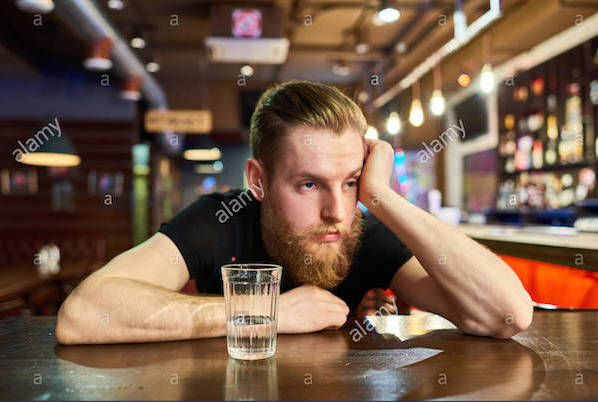

In [3]:
#detect whether the image is private is public

input_image = 'test/test5.jpg' 
imgname = input_image
image = cv2.imread(imgname)
output = image.copy()
output = imutils.resize(output, width=400)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#VGG input size is 224*224 so we resize the input
image = cv2.resize(image, (224, 224))
# convert the image to a floating point data type and perform mean subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
image -= mean
CLASSES = ['private', 'public']
preds = privacy_model.predict(np.expand_dims(image, axis=0))[0]
#0 for private image, 1 for public
i = np.argmax(preds)
label = CLASSES[i]
print label
Image(filename=imgname)


In [4]:
image = load_img(input_image, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
pred = object_model.predict(image)
#decode_predictions function returns the top 1000 objects with probability, we take 10
label = decode_predictions(pred, top=10)[0]
object_list = []
object_prob_list = []

for i in range (0,10):
    object_list.append(str(label[i][1]))
    object_prob_list.append(round(label[i][2],5))

print("[INFO] Object List and Their Probabilities")
print object_list
print object_prob_list

[INFO] Object List and Their Probabilities
['cocktail_shaker', 'beer_glass', 'eggnog', 'restaurant', 'Petri_dish', 'goblet', 'tobacco_shop', 'grocery_store', 'ice_cream', 'red_wine']
[0.2334, 0.08857, 0.06727, 0.04261, 0.03999, 0.03958, 0.02465, 0.02216, 0.02211, 0.02179]


In [5]:
from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import load_img
import csv
import urllib2
from PIL import Image
from cv2 import resize

image = load_img(input_image)
image = np.array(image, dtype=np.uint8)
#VGG input size is 224*224 so we resize the input
image = resize(image, (224, 224))
image = np.expand_dims(image, 0)
predictions_to_return = 5
preds = places_model.predict(image)[0]
#we take top 5 predictions and probabilities, returns unique id of the scenes
top_preds = np.argsort(preds)[::-1][0:predictions_to_return]
top_probs = preds[np.argsort(preds)[-5:]]
top_probs = np.sort(top_probs)[::-1]
file_name = 'categories_places365.txt'

#read scenes from the file and save in classes as string
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

scene_list = []
scene_prob_list = []
for i in range (0,5):
    scene_list.append(classes[top_preds[i]])
    scene_prob_list.append(top_probs[i])

print("[INFO] Scene List and Their Probabilities")
print scene_list
print scene_prob_list

[INFO] Scene List and Their Probabilities
['chemistry_lab', 'biology_laboratory', 'clean_room', 'pharmacy', 'drugstore']
[0.5109832, 0.32993257, 0.056087863, 0.037501868, 0.022853663]


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
column_names = object_list
row_names    = object_list
no_column = len(column_names)
no_rows = len(row_names)
#initialize the whole matrix with zero
a = np.zeros(shape=(no_rows, no_column))
matrix = np.reshape(a, (no_rows, no_column))
df = pd.DataFrame(matrix, columns=column_names, index=row_names)

for i in range (0,10):
    for j in range (0,10):
        if i==j:
            #same object-object cell must be zero
            df.loc[object_list[i]][object_list[j]] = 0.0;
        else:
            #object-object cell value calculation
            df.loc[object_list[i]][object_list[j]] = (df.loc[object_list[i]][object_list[j]] + (object_prob_list[i]*object_prob_list[j]))
            #To draw graph
            G.add_node(object_list[i])
            G.add_node(object_list[j])
            G.add_edge(object_list[i],object_list[j])
            
    
print("[INFO] Object-Object Co-Occurrence Matrix")
df

[INFO] Object-Object Co-Occurrence Matrix


,cocktail_shaker,beer_glass,eggnog,restaurant,Petri_dish,goblet,tobacco_shop,grocery_store,ice_cream,red_wine
cocktail_shaker,0.000000,0.020672,0.015701,0.009945,0.009334,0.009238,0.005753,0.005172,0.005160,0.005086
beer_glass,0.020672,0.000000,0.005958,0.003774,0.003542,0.003506,0.002183,0.001963,0.001958,0.001930
eggnog,0.015701,0.005958,0.000000,0.002866,0.002690,0.002663,0.001658,0.001491,0.001487,0.001466
restaurant,0.009945,0.003774,0.002866,0.000000,0.001704,0.001687,0.001050,0.000944,0.000942,0.000928
Petri_dish,0.009334,0.003542,0.002690,0.001704,0.000000,0.001583,0.000986,0.000886,0.000884,0.000871
goblet,0.009238,0.003506,0.002663,0.001687,0.001583,0.000000,0.000976,0.000877,0.000875,0.000862
tobacco_shop,0.005753,0.002183,0.001658,0.001050,0.000986,0.000976,0.000000,0.000546,0.000545,0.000537
grocery_store,0.005172,0.001963,0.001491,0.000944,0.000886,0.000877,0.000546,0.000000,0.000490,0.000483
ice_cream,0.005160,0.001958,0.001487,0.000942,0.000884,0.000875,0.000545,0.000490,0.000000,0.000482
red_wine,0.005086,0.001930,0.001466,0.000928,0.000871,0.000862,0.000537,0.000483,0.000482,0.000000


In [7]:
column_names = object_list
row_names    = scene_list
no_column = len(column_names)
no_rows = len(row_names)
a = np.zeros(shape=(no_rows, no_column))
#initialize the whole matrix with zero
matrix = np.reshape(a, (no_rows, no_column))
df2 = pd.DataFrame(matrix, columns=column_names, index=row_names)
for i in range (0,10):
    for j in range (0,5):
            df2[object_list[i]][scene_list[j]] = (df2[object_list[i]][scene_list[j]] + (object_prob_list[i]*scene_prob_list[j]))
            #To Draw graph
            G.add_node(object_list[i])
            G.add_node(scene_list[j])
            G.add_edge(object_list[i],scene_list[j])
            

print("[INFO] Object-Scene Co-Occurrence Matrix")    
df2

,cocktail_shaker,beer_glass,eggnog,restaurant,Petri_dish,goblet,tobacco_shop,grocery_store,ice_cream,red_wine
chemistry_lab,0.119263,0.045258,0.034374,0.021773,0.020434,0.020225,0.012596,0.011323,0.011298,0.011134
biology_laboratory,0.077006,0.029222,0.022195,0.014058,0.013194,0.013059,0.008133,0.007311,0.007295,0.007189
clean_room,0.013091,0.004968,0.003773,0.002390,0.002243,0.002220,0.001383,0.001243,0.001240,0.001222
pharmacy,0.008753,0.003322,0.002523,0.001598,0.001500,0.001484,0.000924,0.000831,0.000829,0.000817
drugstore,0.005334,0.002024,0.001537,0.000974,0.000914,0.000905,0.000563,0.000506,0.000505,0.000498


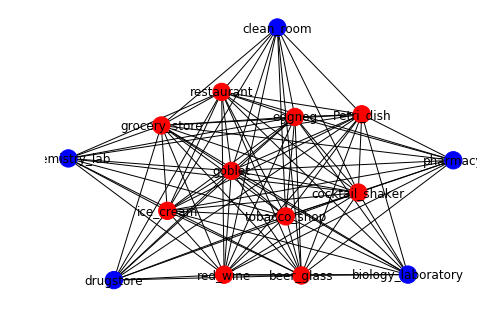

In [8]:
nx.set_node_attributes(G, 'color', 'r')

scn_list = []
color_map = []

for node in G:
    if node in scene_list:
        scn_list.append(node)
        color_map.append('blue')
    else: color_map.append('red')     
        

nx.draw(G,node_color = color_map,with_labels = True)
plt.axis ("off")
plt.show()

In [9]:
#read threshold matrices from disk calculated in Threshold_Calculation.py file
df_ot = pd.read_csv('object_threshold.csv',sep=',',index_col=0)
df_st = pd.read_csv('scene_threshold.csv',sep=',',index_col=0)

In [12]:
#objects = ['gown', 'swimming_trunks', 'groom', 'bubble', 'dalmatian', 'sunglass', 'bathing_cap', 'whippet', 'hammerhead', 'bikini']
#object_prob = [0.07553, 0.05757999999999999, 0.05012, 0.032639999999999995, 0.0306, 0.0295, 0.0263, 0.02621, 0.01906, 0.01816]
#scenes = ['shower', 'bathroom', 'ice_skating_rink/outdoor', 'hotel_room', 'ice_skating_rink/indoor']
#scene_prob = [0.6863218000000001, 0.2923281, 0.006975433299999999, 0.001655356, 0.0014729362]

objects = object_list
object_prob = object_prob_list
scenes = scene_list
scene_prob = scene_prob_list
Gt = nx.Graph()

column_names = objects
row_names    = objects
no_column = len(column_names)
no_rows = len(column_names)
a = np.zeros(shape=(no_rows, no_column))
matrix = np.reshape(a, (no_rows, no_column))
df = pd.DataFrame(matrix, columns=column_names, index=row_names)
for i in range (0,10):
    for j in range (0,10):
        if i==j:
            df.loc[objects[i]][objects[j]] = 0.0;
        else:
            #do extra stuffs in here
            df.loc[objects[i]][objects[j]] =  (object_prob[i]*object_prob[j])
            #uncomment following line to see cell values and threshold values
            print objects[i] + '-' + objects[j]  +  ' ' + str(df.loc[objects[i]][objects[j]]) +  ' : ' + str(df_ot.loc[objects[i]][objects[j]])
            #use df_ot.loc[objects[i]][objects[j]] to replace hardcoded value
            
            if(df.loc[objects[i]][objects[j]] > 0.01):
                print objects[i] + '-' + objects[j]
                Gt.add_node(objects[i])
                Gt.add_node(objects[j])
                Gt.add_edge(objects[i],objects[j])
            
    
column_names = objects
row_names    = scenes
no_column = len(column_names)
no_rows = len(row_names)
a = np.zeros(shape=(no_rows, no_column))
matrix = np.reshape(a, (no_rows, no_column))
df2 = pd.DataFrame(matrix, columns=column_names, index=row_names)
for i in range (0,10):
    for j in range (0,5):
            df2[objects[i]][scenes[j]] = (df2[objects[i]][scenes[j]] + (object_prob[i]*scene_prob[j]))
            
            #use df_st.loc[objects[i]][scenes[j]] to replace hardcoded value
            if df2[objects[i]][scenes[j]] > 0.01:
                print objects[i] + '-' + scenes[j]
                
                Gt.add_node(objects[i])
                Gt.add_node(scenes[j])
                Gt.add_edge(objects[i],scenes[j])
                

cocktail_shaker-beer_glass 0.020672238 : 0.06664211541708964
cocktail_shaker-beer_glass
cocktail_shaker-eggnog 0.015700818 : 0.08943077153796622
cocktail_shaker-eggnog
cocktail_shaker-restaurant 0.009945174000000001 : 0.3435423254667009
cocktail_shaker-Petri_dish 0.009333666 : 0.0
cocktail_shaker-goblet 0.009237971999999999 : 0.10366580523524588
cocktail_shaker-tobacco_shop 0.005753309999999999 : 0.5
cocktail_shaker-grocery_store 0.005172144 : 0.29209369499932925
cocktail_shaker-ice_cream 0.005160474 : 0.04956108695672118
cocktail_shaker-red_wine 0.005085786 : 0.17228161357741126
beer_glass-cocktail_shaker 0.020672238 : 0.06664211541708964
beer_glass-cocktail_shaker
beer_glass-eggnog 0.005958103899999999 : 0.1003054466384442
beer_glass-restaurant 0.0037739677 : 0.09520602529327883
beer_glass-Petri_dish 0.0035419143 : 0.001352328530698189
beer_glass-goblet 0.0035056005999999995 : 0.0620933647419132
beer_glass-tobacco_shop 0.0021832504999999996 : 0.5
beer_glass-grocery_store 0.0019627112

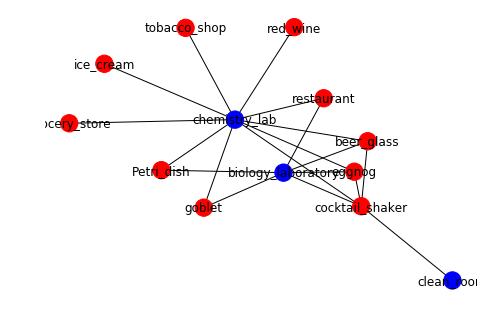

In [13]:
#color the object nodes as red and scene nodes as blue
nx.set_node_attributes(Gt, 'color', 'r')
scn_list = []
color_map = []

for node in Gt:
    if node in scene_list:
        scn_list.append(node)
        color_map.append('blue')
    else: color_map.append('red')     
        
nx.draw(Gt,node_color = color_map,with_labels = True)
plt.axis ("off")
plt.show()


goblet
cocktail_shaker
restaurant
grocery_store
red_wine
Petri_dish
eggnog
tobacco_shop
ice_cream
beer_glass


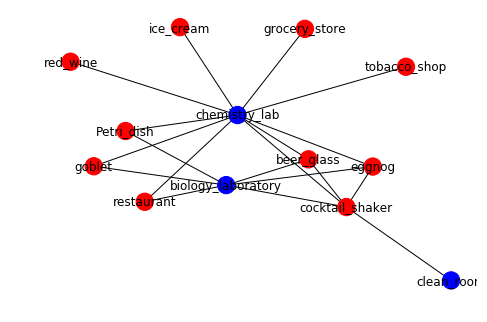

In [15]:
#traverse all scene nodes and find the end nodes and add them to list
vertices = set([])

for node in Gt:
    if node in scene_list:
        edges =  Gt.edges(node)
        l = list(edges)
        #print l
        for i in range(0,len(l)):
            #print l[i][1]
            vertices.add(l[i][1])

for node in Gt:
    if node in vertices:
        print node

nx.draw(Gt,node_color = color_map,with_labels = True)
plt.axis ("off")
plt.show()

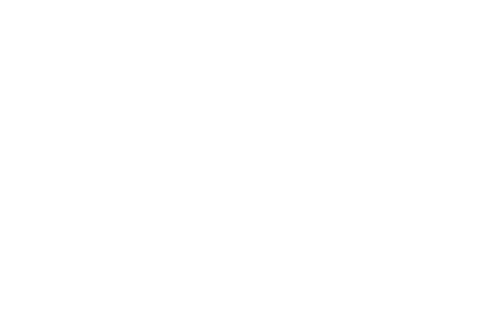

In [16]:
#remove scene nodes and ending nodes
for obj in vertices:
    Gt.remove_node(obj)

for scn in scn_list:
    Gt.remove_node(scn)
    
color_map = []
for node in Gt:
    if node in scenes:
        color_map.append('blue')
    else: color_map.append('red')  

nx.draw(Gt,node_color = color_map,with_labels = True)
plt.axis ("off")
plt.show()

In [17]:
#apply vertex covering algorithm to rest of the graph and merge with previous set of nodes

from networkx.algorithms.approximation import vertex_cover
mincover = vertex_cover.min_weighted_vertex_cover(G)
set(list(mincover) + list(vertices))

{'Petri_dish',
 'beer_glass',
 'biology_laboratory',
 'chemistry_lab',
 'clean_room',
 'cocktail_shaker',
 'drugstore',
 'eggnog',
 'goblet',
 'grocery_store',
 'ice_cream',
 'pharmacy',
 'red_wine',
 'restaurant',
 'tobacco_shop'}